In [1]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanorama

from pathlib import Path

In [2]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

-----
anndata     0.9.2
scanpy      1.9.8
-----
PIL                 10.4.0
annoy               NA
appnope             0.1.4
asttokens           NA
backcall            0.2.0
backports           NA
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0
debugpy             1.6.7
decorator           5.1.1
executing           2.1.0
fbpca               NA
h5py                3.11.0
importlib_resources NA
intervaltree        NA
ipykernel           6.29.5
jaraco              NA
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.7
llvmlite            0.41.1
matplotlib          3.7.5
more_itertools      10.3.0
mpl_toolkits        NA
natsort             8.4.0
numba               0.58.1
numpy               1.24.4
packaging           24.2
pandas              2.0.3
parso               0.8.4
patsy               1.0.1
pexpect             4.9.0
pickleshare         0.7.5
pkg_resources       NA
platformdirs        4.3.6
prompt_toolk

In [3]:
adata_spatial_anterior = sc.datasets.visium_sge(
    sample_id="V1_Mouse_Brain_Sagittal_Anterior"
)
adata_spatial_posterior = sc.datasets.visium_sge(
    sample_id="V1_Mouse_Brain_Sagittal_Posterior"
)

100%|██████████| 8.81M/8.81M [00:01<00:00, 5.36MB/s]
100%|██████████| 19.6M/19.6M [00:03<00:00, 5.32MB/s]

reading /Users/jacksonzhang/Desktop/program/spatial data scanorama/data/V1_Mouse_Brain_Sagittal_Anterior/filtered_feature_bc_matrix.h5


 (0:00:00)


/opt/anaconda3/envs/scanorama_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/scanorama_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
100%|██████████| 9.26M/9.26M [00:01<00:00, 5.63MB/s]
100%|██████████| 20.1M/20.1M [00:03<00:00, 5.45MB/s]

reading /Users/jacksonzhang/Desktop/program/spatial data scanorama/data/V1_Mouse_Brain_Sagittal_Posterior/filtered_feature_bc_matrix.h5


 (0:00:00)


/opt/anaconda3/envs/scanorama_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/scanorama_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
adata_spatial_anterior.var_names_make_unique()
adata_spatial_posterior.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata_spatial_anterior, inplace=True)
sc.pp.calculate_qc_metrics(adata_spatial_posterior, inplace=True)

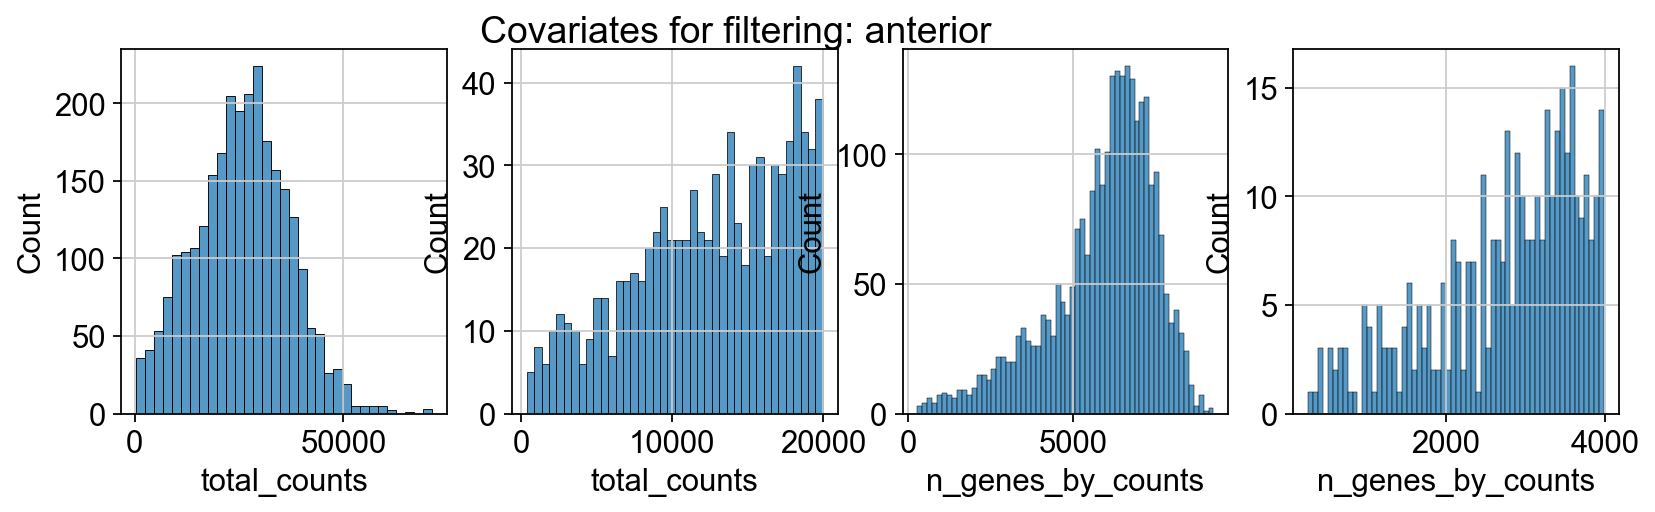

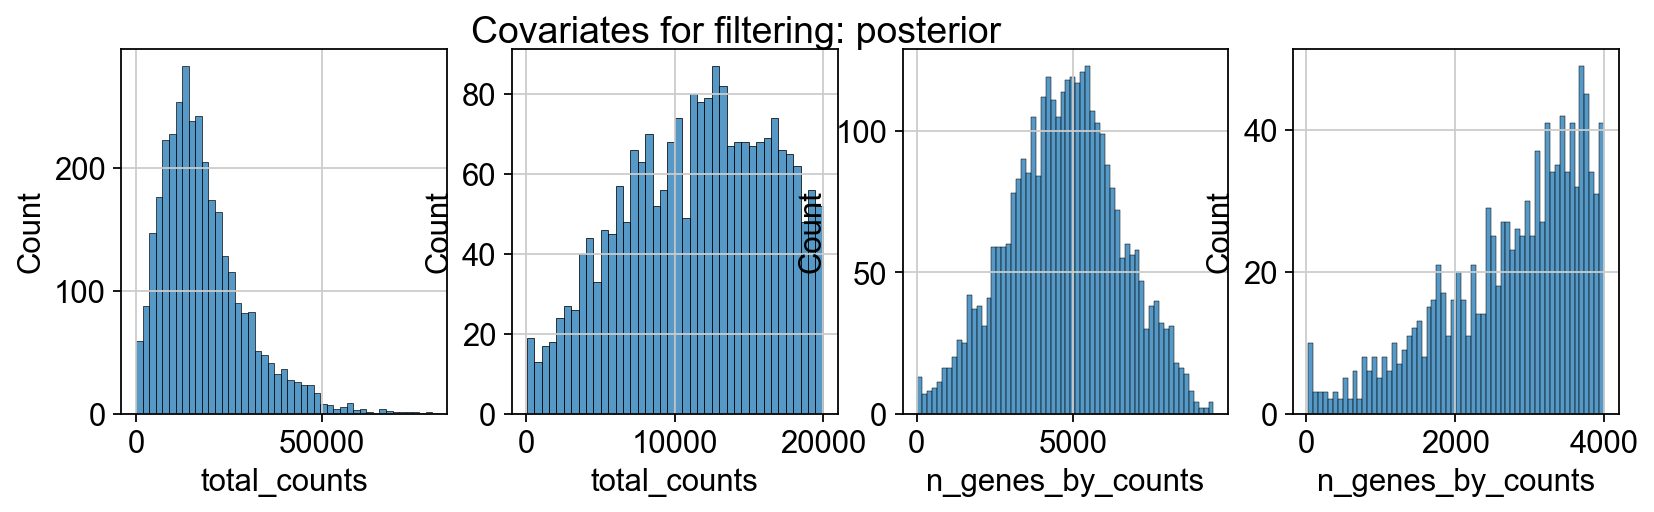

In [5]:
for name, adata in [
    ("anterior", adata_spatial_anterior),
    ("posterior", adata_spatial_posterior),
]:
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    fig.suptitle(f"Covariates for filtering: {name}")

    sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
    sns.histplot(
        adata.obs["total_counts"][adata.obs["total_counts"] < 20000],
        kde=False,
        bins=40,
        ax=axs[1],
    )
    sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
    sns.histplot(
        adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
        kde=False,
        bins=60,
        ax=axs[3],
    )

In [6]:
for adata in [
    adata_spatial_anterior,
    adata_spatial_posterior,
]:
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000, inplace=True)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [7]:
adatas = [adata_spatial_anterior, adata_spatial_posterior]
adatas_cor = scanorama.correct_scanpy(adatas, return_dimred=True)

Found 32285 genes among all datasets
[[0.         0.47928465]
 [0.         0.        ]]
Processing datasets (0, 1)


In [8]:
adata_spatial = sc.concat(
    adatas_cor,
    label="library_id",
    uns_merge="unique",
    keys=[
        k
        for d in [
            adatas_cor[0].uns["spatial"],
            adatas_cor[1].uns["spatial"],
        ]
        for k, v in d.items()
    ],
    index_unique="-",
)

In [11]:
sc.pp.neighbors(adata_spatial, use_rep="X_scanorama")
sc.tl.umap(adata_spatial)
sc.tl.leiden(adata_spatial, key_added="clusters", n_iterations=2, directed=False)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
running Leiden clustering
    finished: found 22 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


/opt/anaconda3/envs/scanorama_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/anaconda3/envs/scanorama_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


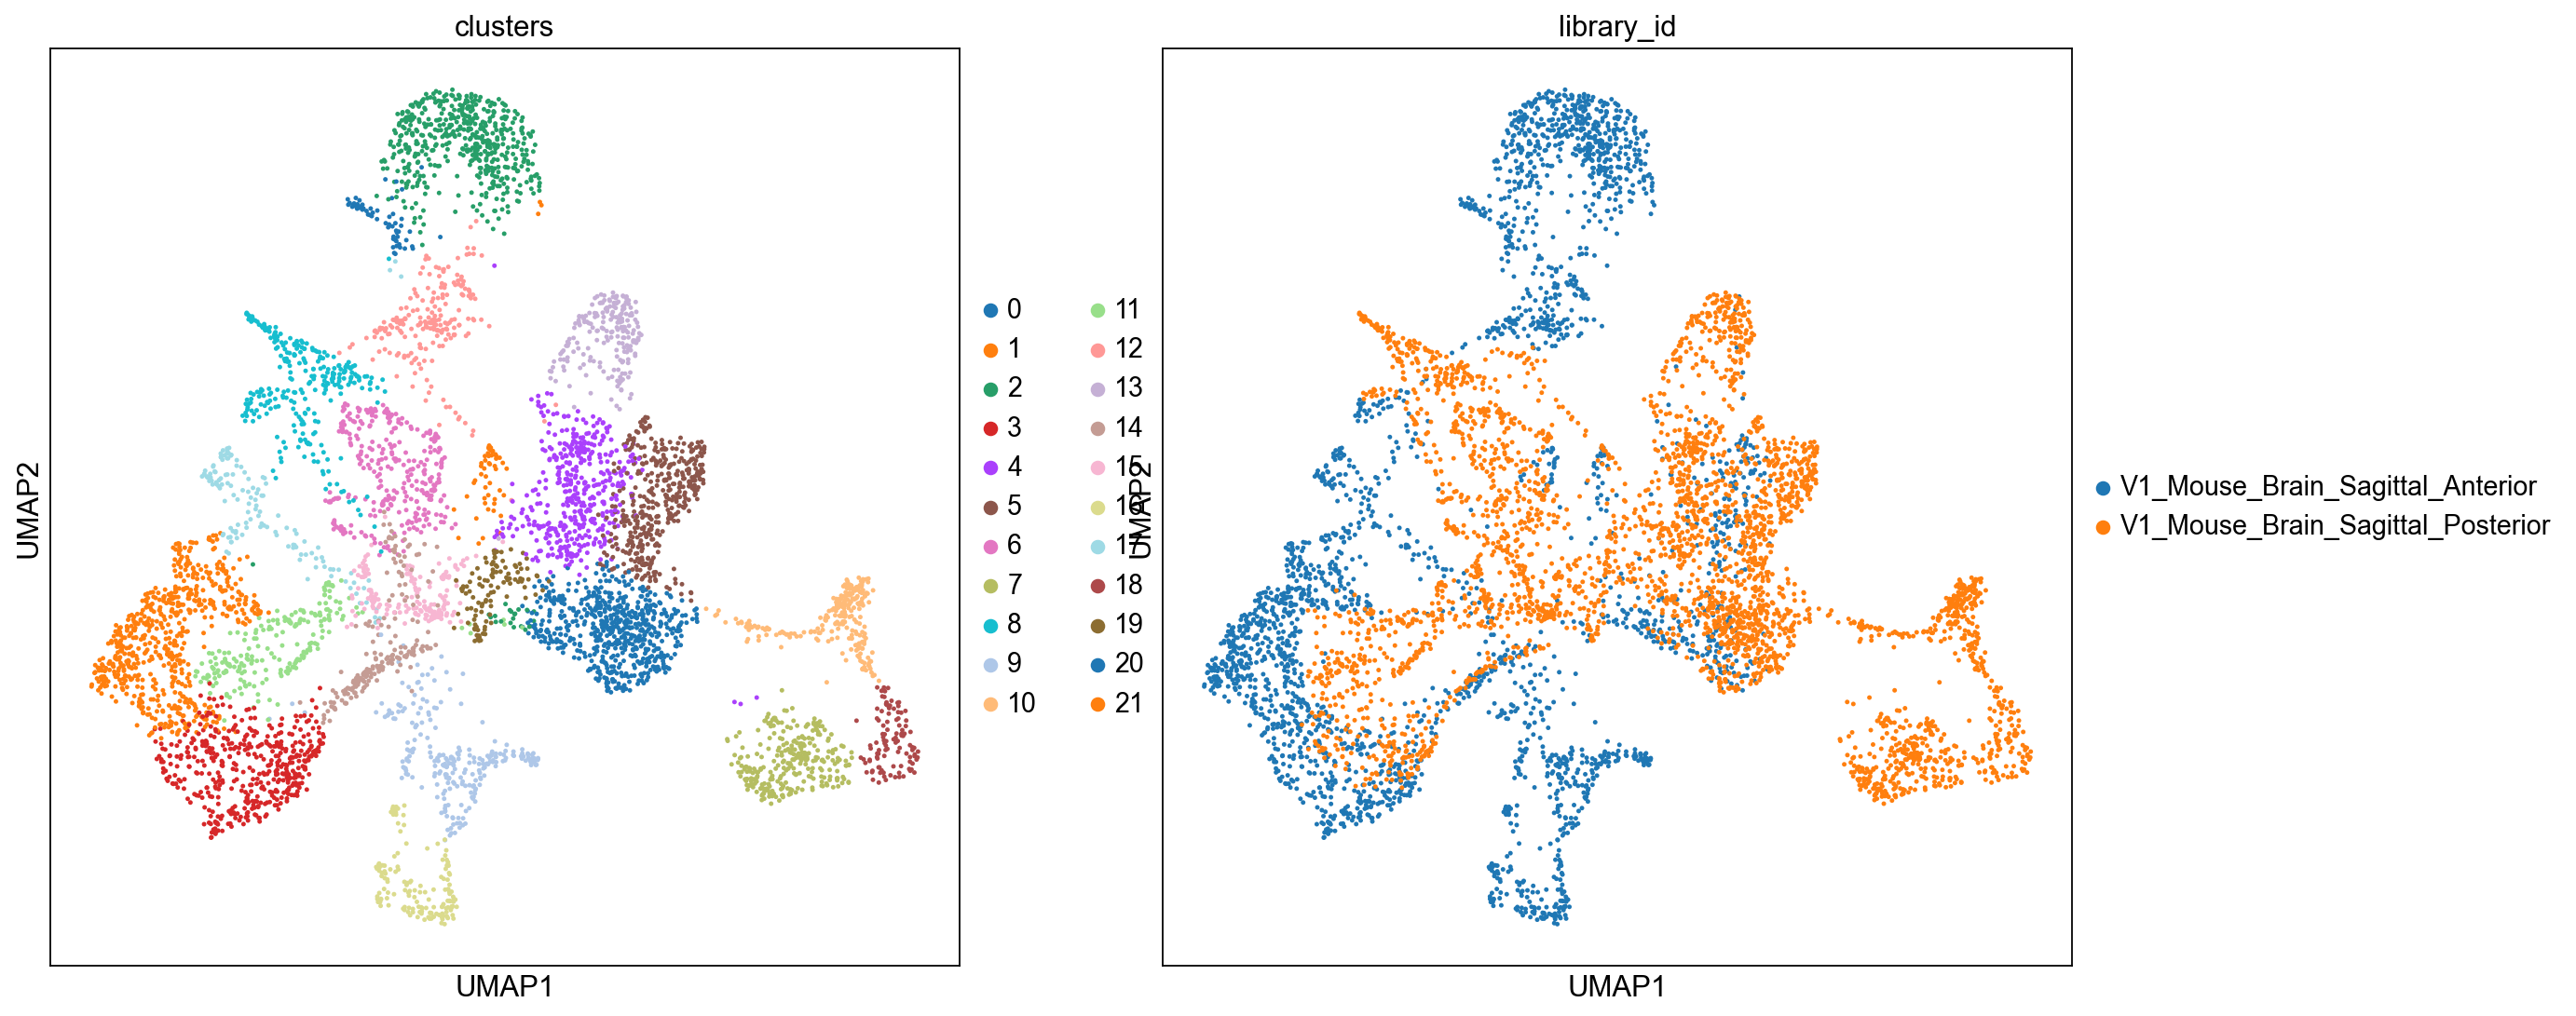

In [12]:
sc.pl.umap(
    adata_spatial, color=["clusters", "library_id"], palette=sc.pl.palettes.default_20
)

In [13]:
clusters_colors = dict(
    zip([str(i) for i in range(18)], adata_spatial.uns["clusters_colors"])
)

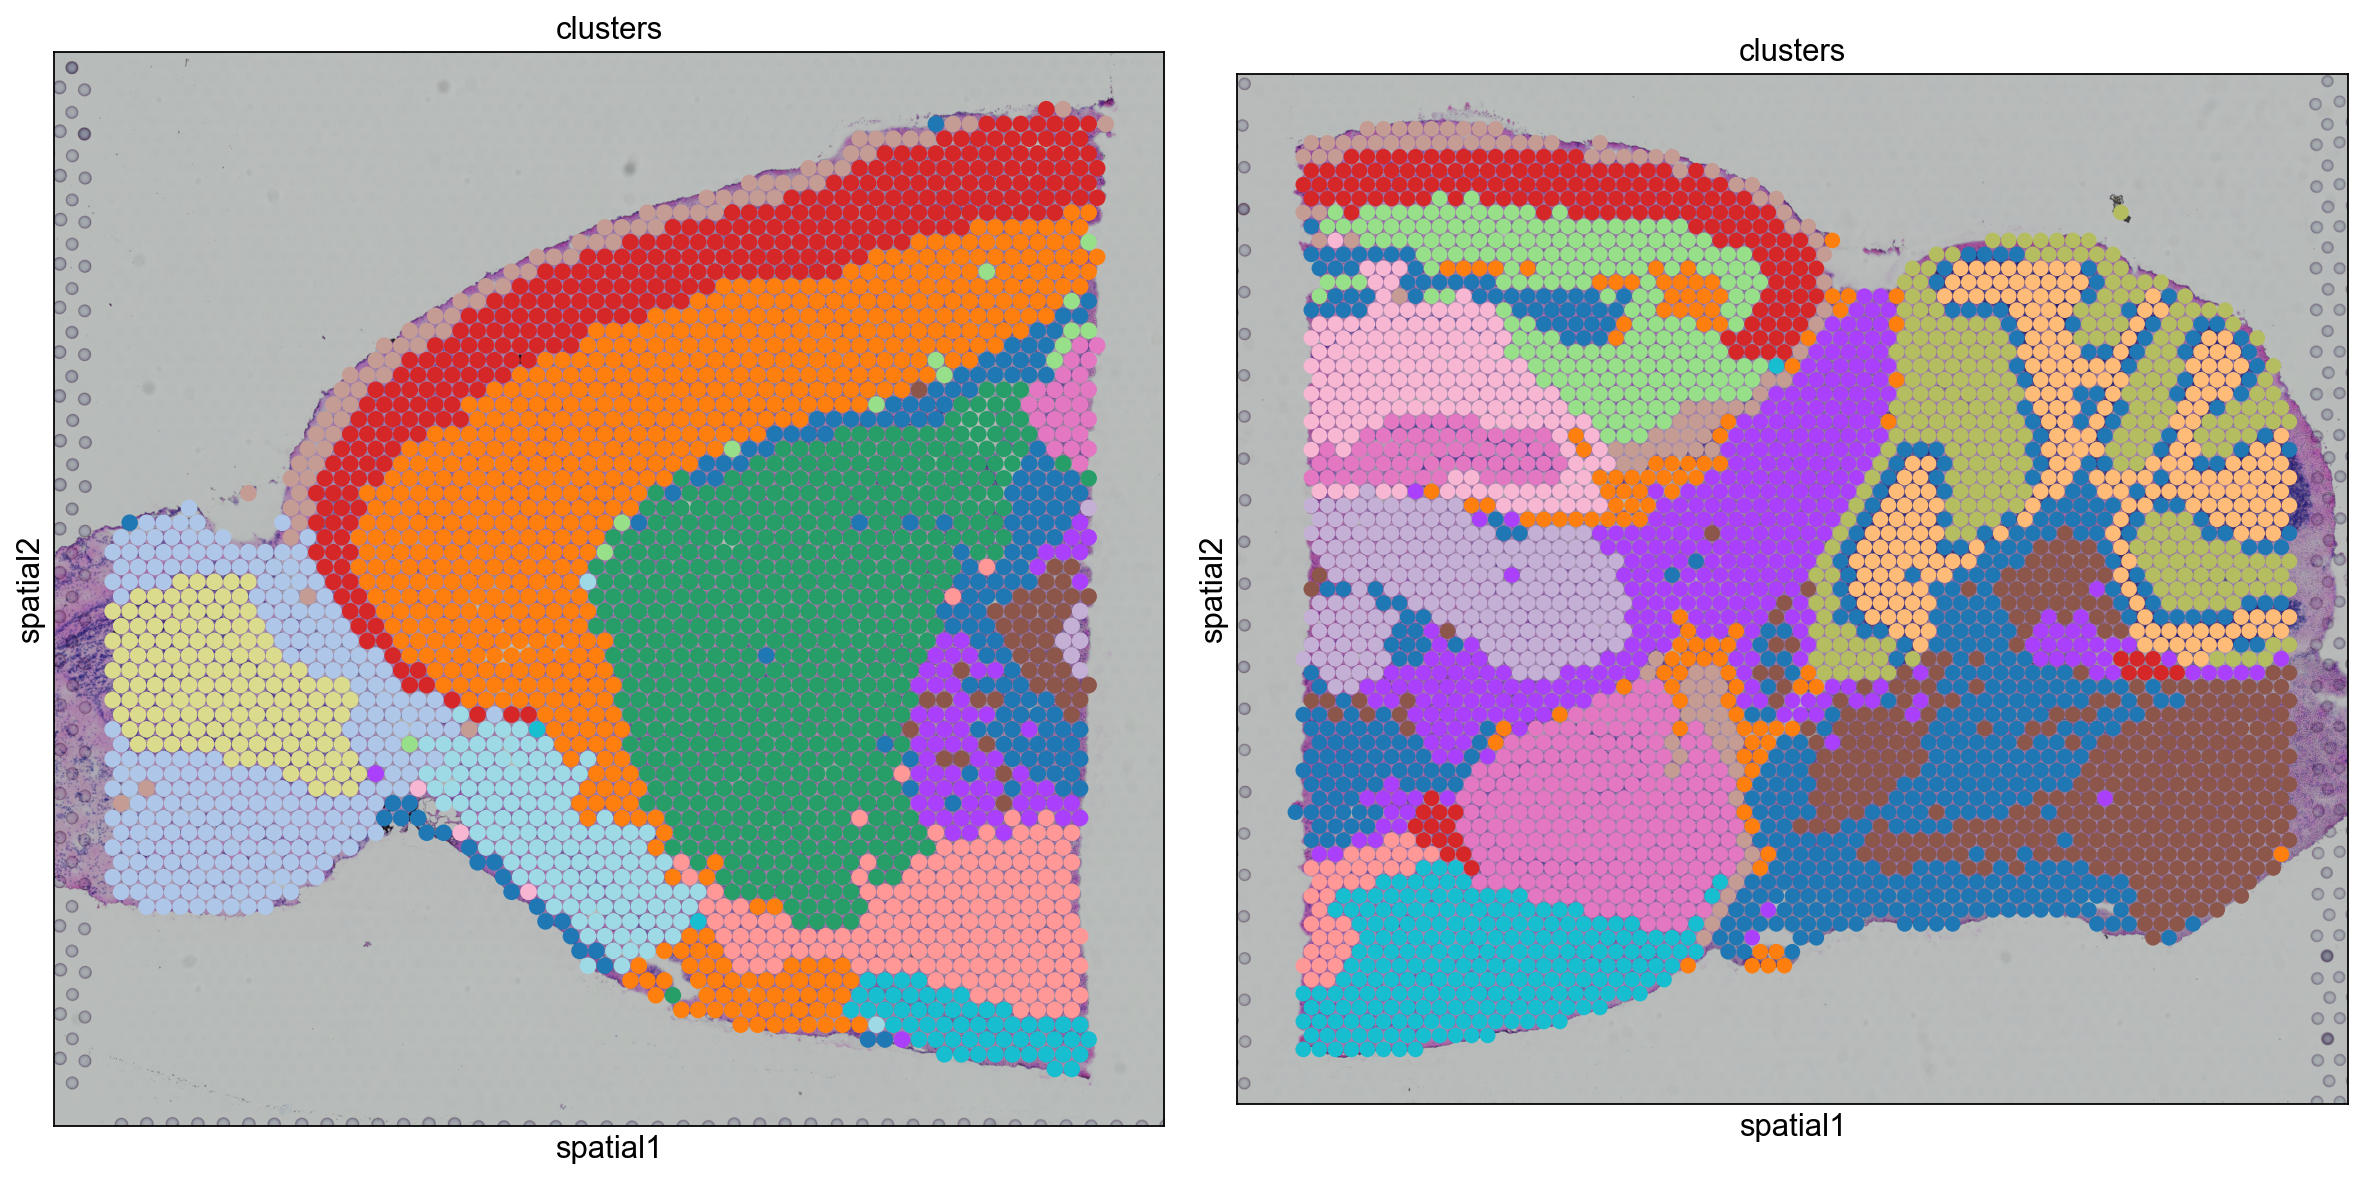

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

for i, library in enumerate(
    ["V1_Mouse_Brain_Sagittal_Anterior", "V1_Mouse_Brain_Sagittal_Posterior"]
):
    ad = adata_spatial[adata_spatial.obs.library_id == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        color="clusters",
        size=1.5,
        palette=[
            v
            for k, v in clusters_colors.items()
            if k in ad.obs.clusters.unique().tolist()
        ],
        legend_loc=None,
        show=False,
        ax=axs[i],
    )

plt.tight_layout()